# 11. Region properties

Once you have segmented an image you usually want to gather information on the objects that you "discovered". Instead of painstakingly do this manually, skimage offers a simplified way to do this with its regionprops tool.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage
import skimage.io
import skimage.morphology

Let's first recreate our two masks and first focus on the nuclei segmentation:

In [2]:
#image_stack = skimage.io.imread('../Data/myoblast.tif')
#image_stack = skimage.io.imread('https://cildata.crbs.ucsd.edu/media/images/13585/13585.tif')
image_stack  = skimage.io.imread('https://cildata.crbs.ucsd.edu/media/images/13587/13587.tif')
image_nuclei = image_stack[:,:,2]#blue channel in RGB
image_cells = image_stack[:,:,1]#green channel in RGB

mask_nuclei = image_nuclei > skimage.filters.threshold_otsu(image_nuclei)
mask_cells = image_cells > skimage.filters.threshold_otsu(image_cells)

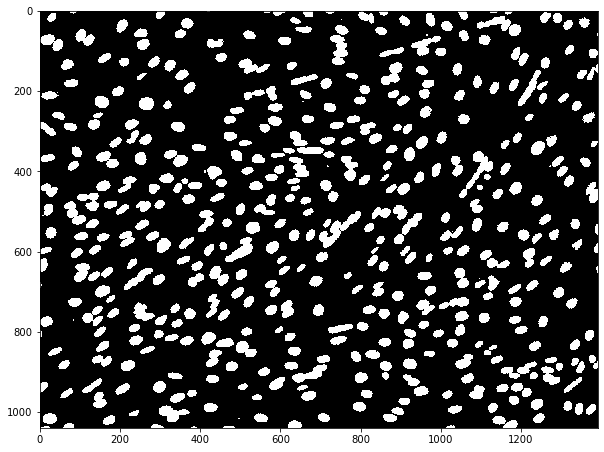

In [3]:
plt.subplots(figsize=(10,10))
plt.imshow(mask_nuclei, cmap = 'gray')
plt.show()

## 11.1 Labelling

In order to measure objects in the image separately, we first need to label them individually. For that we can just use the ```skimage.morphology.label()``` function which looks for independent groups of white pixels and assigns them integer numbers:

In [4]:
my_labels = skimage.morphology.label(mask_nuclei)

The label map shows that numbers are assigned from top to bottom in the image:

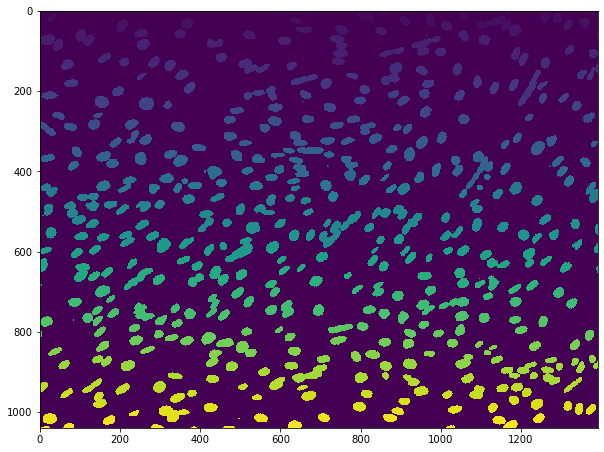

In [5]:
plt.subplots(figsize=(10,10))
plt.imshow(my_labels)
plt.show()

## 11.2 Region properties

Now that we have each region labeled with a different number we can use the ```skimage.measure.regionprops()``` function, which takes such as label map and analyzed the geometric properties of each region:

In [6]:
my_regions = skimage.measure.regionprops(my_labels)

What is exactly the output?

In [7]:
type(my_regions)

list

In [8]:
len(my_regions)

453

So it seems we have a list with 543 positions, i.e. the 543 nuclei detected in the image. Let's look at one of the elements of the list:

In [9]:
my_regions[100]

This looks like an object that we don't know yet. We can either try to figure out what the object is ourselves or go read definitions on the [scikit-image webpage](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops).

The explanation tells us that we can recover a large number of different parameters for each region, including geometric parameters, cropped images, coordinates etc... Also the way to access a specific property is explained to us. Let's try to recover the 'area' property for the 100th region.

In [10]:
my_regions[100].area

448

Or the cropped image corresponding to this region:

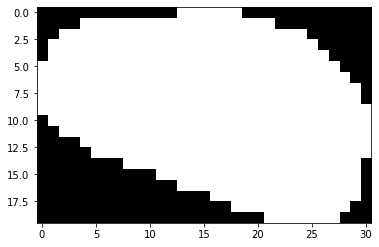

In [11]:
plt.imshow(my_regions[100].image, cmap = 'gray')
plt.show()

## 11.3 Recovering image intensity information

In what we did above, we only recovered information about our white regions. However often we want to obtain information on pixel values of the **original** image. For example, "what is the average intensity of each nucleus?"

Luckily ```regionprops``` allows us to pass as additional argument the image we want to use to quantify intensity:

In [12]:
my_regions = skimage.measure.regionprops(my_labels,intensity_image=image_nuclei)

Now we have access to additional parameters. For example the mean_intensity in each nucleus:

In [13]:
my_regions[100].mean_intensity

129.39285714285714

## 11.4 Aggregating information of all nuclei

If we want get some statistic from our analysis, we need now to aggregate the information from all these nuclei. We have seen that ```for``` loops allow us to go easily through lists, so we will try to use a for loop here to visit every measured region.

```my_region``` is a list, so we can visit every element using:
```
for elem in my_regions:
    do something with the specific region elem
```
For example recover the area:

In [14]:
for elem in my_regions:
    print(elem.area)

87
368
23
90
282
346
135
225
404
102
137
719
539
401
635
495
487
1566
308
497
618
685
2
470
580
748
590
522
456
592
1197
481
548
515
22
1421
28
2061
593
1624
566
780
693
396
519
746
460
418
548
513
541
558
443
541
1576
620
612
386
1696
546
492
495
620
1568
433
242
351
961
519
599
535
573
523
338
551
606
460
583
684
724
506
522
485
442
645
3
390
398
561
892
475
1016
336
12
468
583
599
624
467
564
448
246
295
573
511
519
485
638
640
650
726
694
525
797
536
478
318
412
554
1012
593
595
409
635
593
540
734
566
498
437
351
379
212
938
530
442
536
1001
761
345
642
543
1299
351
2294
773
349
544
595
803
995
1544
471
1436
469
471
350
600
538
443
9
9
888
490
456
33
556
677
455
221
199
534
511
938
206
379
439
641
747
635
1118
568
760
411
698
870
557
414
168
248
504
329
522
831
501
385
603
530
575
386
778
449
520
742
611
1598
539
585
819
502
887
957
341
1313
2959
447
1224
525
8
675
396
277
477
531
470
574
866
572
416
176
967
622
504
630
631
488
1008
571
7
529
499
415
495
338
2012
613
992
400
760
3

Of course we have just printed those numbers on our screen here. Now we want to put all these elements in a list:

In [15]:
my_areas = []
for elem in my_regions:
    my_areas.append(elem.area)

```my_areas``` is now indeed a list of numbers corresponding to each segmented region. We can look at a histogram of those values to get an idea of their distribution:

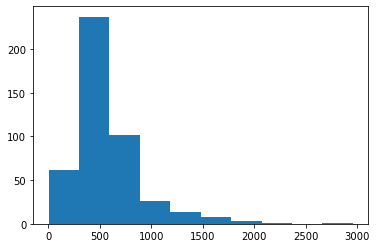

In [16]:
plt.hist(my_areas)
plt.show()

We can refine the bins to focus on the "interesting" part:

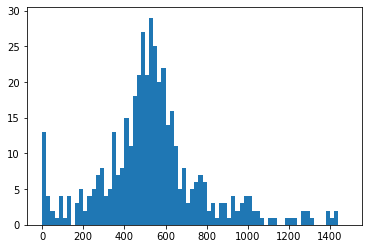

In [17]:
plt.hist(my_areas, bins = np.arange(0,1500,20))
plt.show()

So most of the nuclei have an area around 500 pixels, and in what follows, we might want to set some limit where we exclude objects as not being nuclei, e.g.

In [18]:
my_areas = []
for elem in my_regions:
    if elem.area > 200:
        if elem.area <700:
            my_areas.append(elem.area)

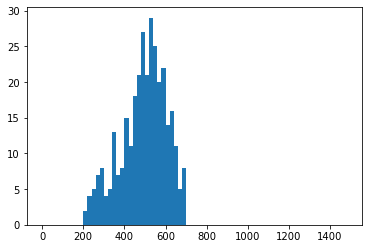

In [19]:
plt.hist(my_areas, bins = np.arange(0,1500,20))
plt.show()

So now we know that we can use the area as a sort of filter to only keep "nuclei-like" features. But we want to recover much more information. Instead of just appending single values (like the area) to our list as we did above, we can append a dictionary with a series of parameters:

In [63]:
my_values = []
for elem in my_regions:
    if elem.area > 200:
        if elem.area <700:
            
            #before we just added the area value to the list:
            #my_areas.append(elem.area)
            
            #now we add a whole dictionary:
            current_dict = {'area': elem.area, 'intensity': elem.mean_intensity, 'extent': elem.major_axis_length}
            my_values.append(current_dict)

/Users/gw18g940/miniconda3/envs/teaching_test/lib/python3.6/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/Users/gw18g940/miniconda3/envs/teaching_test/lib/python3.6/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


In [64]:
my_values

[{'area': 368, 'intensity': 123.125, 'extent': 25.542008847106832},
 {'area': 282, 'intensity': 98.7517730496454, 'extent': 31.107408204383873},
 {'area': 346, 'intensity': 105.10982658959537, 'extent': 26.63481862072005},
 {'area': 225, 'intensity': 100.49777777777778, 'extent': 24.081045853624914},
 {'area': 404, 'intensity': 111.7871287128713, 'extent': 26.865358904909005},
 {'area': 539, 'intensity': 82.8886827458256, 'extent': 31.60489009605655},
 {'area': 401, 'intensity': 137.34413965087282, 'extent': 27.00010551010861},
 {'area': 635, 'intensity': 137.48346456692914, 'extent': 36.02854822251474},
 {'area': 495, 'intensity': 99.30909090909091, 'extent': 26.44332674762754},
 {'area': 487, 'intensity': 108.59548254620123, 'extent': 29.674300000142818},
 {'area': 308, 'intensity': 165.06493506493507, 'extent': 28.22689646240874},
 {'area': 497, 'intensity': 85.50301810865191, 'extent': 25.73919664371138},
 {'area': 618, 'intensity': 92.77184466019418, 'extent': 31.139422467965673},

We have seen previously a way to nicely organise this information by creating a Pandas dataframe. Let's use it here again:

In [65]:
my_table = pd.DataFrame(my_values)

In [66]:
my_table

,area,extent,intensity
0,368,25.542009,123.125000
1,282,31.107408,98.751773
2,346,26.634819,105.109827
3,225,24.081046,100.497778
4,404,26.865359,111.787129
5,539,31.604890,82.888683
6,401,27.000106,137.344140
7,635,36.028548,137.483465
8,495,26.443327,99.309091
9,487,29.674300,108.595483


And we can do some statistical analysis on these data:

In [67]:
my_table.mean()

area         493.079755
extent        31.623512
intensity    119.279365
dtype: float64

In [68]:
my_table.std()

area         110.442661
extent         4.698548
intensity     22.750826
dtype: float64

We can also plot histograms:

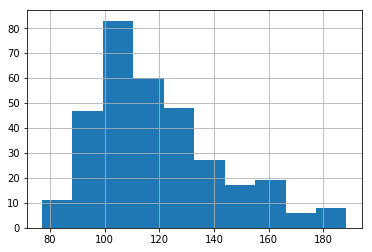

In [69]:
my_table.intensity.hist()

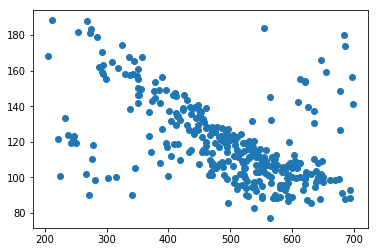

In [70]:
plt.plot(my_table.area, my_table.intensity, 'o')

This last plot clearly shows a correlation between nuclei size and their intensity. The dye used here binds to DNA, so this indicates that chromosomes are more densely packed in small nuclei, which makes perfect sense.